In [1]:
# import the necessary packages
from facebook_scraper import get_posts
from twitter_scraper import get_tweets
import seaborn as sns
import pandas as pd
import numpy as np
import time
import json
import re

from AttributeRelevance import *
from Features import *

# Part - 1: Data Collection

## Scrape facebook

In [2]:
# define a function to scrape facebook posts
def scrape_facebook(accounts):
    posts = []
    count = 0
    for account in accounts:
        for post in get_posts(account):
            try:
                post_dict = {}
                post_dict["post_id"] = post["post_id"]
                post_dict["text"] = post["text"]
                post_dict["post_text"] = post["post_text"]
                post_dict["shared_text"] = post["shared_text"]
                post_dict["time"] = post["time"]
                post_dict["image"] = post["image"]
                post_dict["video"] = post["video"]
                post_dict["video_thumbnail"] = post["video_thumbnail"]
                post_dict["video_id"] = post["video_id"]
                post_dict["likes"] = post["likes"]
                post_dict["comments"] = post["comments"]
                post_dict["shares"] = post["shares"]
                post_dict["post_url"] = post["post_url"]
                post_dict["link"] = post["link"]
                post_dict["user_id"] = post["user_id"]
                post_dict["images"] = post["images"]
                posts.append(post_dict)
            except:
                continue
        count += 1
        print(f"complete scrapping {count} accounts out of {len(accounts)} accounts")
            
    return posts

In [3]:
# facebook pages to be scrape which are related to SRH and GBV
facebook_accounts = ["SRHMJournal", "FSRH.UK", "mmsa.scora", "BMJ.SRH", 
                     "BLreproductivehealth", "actioncanadaSHR", "GBVPrevNetwork", 
                     "StopGBVatWork", "16DaysCampaign", "SayNO.UNiTE", "TheYellowMovementAau"]

# scrape facebook posts related to SRH and GBV
start = time.time()
posts = scrape_facebook(facebook_accounts)
end = time.time()
print(f"data scraping takes: {(end - start)} seconds")
fb_posts_df = pd.DataFrame(posts)
fb_posts_df.shape

complete scrapping 1 accounts out of 11 accounts
complete scrapping 2 accounts out of 11 accounts
complete scrapping 3 accounts out of 11 accounts
complete scrapping 4 accounts out of 11 accounts
complete scrapping 5 accounts out of 11 accounts
complete scrapping 6 accounts out of 11 accounts
complete scrapping 7 accounts out of 11 accounts
complete scrapping 8 accounts out of 11 accounts
complete scrapping 9 accounts out of 11 accounts
complete scrapping 10 accounts out of 11 accounts
complete scrapping 11 accounts out of 11 accounts
data scraping takes: 1020.8554711341858 seconds
            post_id                                               text  \
0  4183582811698940  New research finds that by using #photovoice, ...   
1  4181041485286406  We cannot overlook #reprohealth and #reprorigh...   
2  4179768305413724  Our latest editorial is now available online. ...   
3  4178431158880772  Evidence of the #health system challenges to p...   
4  4176874072369814  President Biden repe

In [4]:
AWAREsg_df = pd.read_csv("../data/AWAREsg.csv")
AWAREsg_df.shape

(38, 16)

In [5]:
emerge_global_df = pd.read_csv("../data/EmergeGlobal.csv")
emerge_global_df = emerge_global_df.drop(columns=["Unnamed: 16", "Unnamed: 17"])
emerge_global_df.shape

(38, 16)

In [6]:
equality_now_df = pd.read_csv("../data/equalitynow.csv")
equality_now_df.shape

(38, 16)

In [7]:
girls_are_not_for_sale_df = pd.read_csv("../data/girlsarenotforsale.csv")
girls_are_not_for_sale_df.shape

(26, 16)

In [130]:
# concatinating the scrapped dataframes
frames = [fb_posts_df, AWAREsg_df, emerge_global_df, equality_now_df, girls_are_not_for_sale_df]
df = pd.concat(frames)
df.head()

,post_id,text,post_text,shared_text,time,image,video,video_thumbnail,video_id,likes,comments,shares,post_url,link,user_id,images
0,4183582811698940,"New research finds that by using #photovoice, ...","New research finds that by using #photovoice, ...",,2021-02-04 13:25:03,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,None,None,None,2.0,0.0,0,None,https://bit.ly/2XZFJyV,126697227387539,[https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0...
1,4181041485286406,We cannot overlook #reprohealth and #reprorigh...,We cannot overlook #reprohealth and #reprorigh...,SRHM.ORG\nCall for Papers: COVID-19,2021-02-03 13:25:03,None,None,None,None,3.0,0.0,0,https://facebook.com/story.php?story_fbid=4181...,http://www.srhm.org/call-for-papers-covid19/,126697227387539,[]
2,4179768305413724,Our latest editorial is now available online. ...,Our latest editorial is now available online. ...,TANDFONLINE.COM\nA round-up of articles in 2020,2021-02-03 00:41:05,None,None,None,None,0.0,0.0,0,https://facebook.com/story.php?story_fbid=4179...,https://bit.ly/3oDquXj,126697227387539,[]
3,4178431158880772,Evidence of the #health system challenges to p...,Evidence of the #health system challenges to p...,,2021-02-02 13:25:03,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,None,None,None,3.0,0.0,0,None,https://bit.ly/3qC86PZ,126697227387539,[https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0...
4,4176874072369814,President Biden repeals the Global Gag Rule - ...,President Biden repeals the Global Gag Rule - ...,,2021-02-01 21:48:36,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,None,None,None,1.0,0.0,0,None,https://mailchi.mp/c0533878aec1/your-april-new...,126697227387539,[https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0...


In [131]:
df.shape

(564, 16)

In [132]:
df.to_csv('../data/fb_posts.csv', index=False)

In [39]:
df = pd.read_csv('../data/fb_posts.csv')
df.shape

(564, 16)

## Scrape twitter

In [7]:
# define a function to scrape twitter tweets
def scrape_twitter(accounts):
    tweets = []
    count = 0
    for account in accounts:
        for tweet in get_tweets(account):
            try:
                tweet_dict = {}
                tweet_dict["tweetId"] = tweet["tweetId"]
                tweet_dict["userId"] = tweet["userId"]
                tweet_dict["username"] = tweet["username"]
                tweet_dict["tweetUrl"] = tweet["tweetUrl"]
                tweet_dict["isRetweet"] = tweet["isRetweet"]
                tweet_dict["isPinned"] = tweet["isPinned"]
                tweet_dict["time"] = tweet["time"]
                tweet_dict["text"] = tweet["text"]
                tweet_dict["replies"] = tweet["replies"]
                tweet_dict["retweets"] = tweet["retweets"]
                tweet_dict["comments"] = tweet["comments"]
                tweet_dict["likes"] = tweet["likes"]
                tweet_dict["entries"] = tweet["entries"]
                tweets.append(tweet_dict)
            except:
                continue
        count += 1
        print(f"complete scrapping {count} accounts out of {len(accounts)} accounts")
            
    return posts

In [10]:
# facebook pages to be scrape which are related to SRH and GBV
twitter_accounts = ["psrhjournal", "bmj_srh", "reprod_health"]

# scrape facebook posts related to SRH and GBV
start = time.time()
tweets = scrape_twitter(twitter_accounts)
end = time.time()
print(f"data scraping takes: {(end - start)} seconds")
twitter_tweets_df = pd.DataFrame(tweets)
twitter_tweets_df.shape

In [ ]:
twitter_tweets_df.head()

# Part - 2: Data Cleaning and Transforming

## Text cleaning

In [40]:
# drop amharic posts
df = df[df['text'].apply(lambda txt: not re.search(r"[\u1200-\u137F]+", str(txt)))]
df.shape

(529, 16)

In [41]:
# drop post with empty text
df["text"] = df["text"].replace({"", np.nan})
df = df.dropna(subset=["text"])
df.shape

(520, 16)

In [42]:
# content based cleaning 
# define keyword group count
def keyword_group_count(txt):
    f = open("../data/keywords.json")
    keywords = json.load(f)
    f.close()
    count = 0
    for keyword_list in keywords.values():
        for keyword in keyword_list:
            if str(keyword).lower() in txt.lower():
                count += 1
                break
    return count

# add keyword group count columns
df["keyword_group_count"] = df["text"].apply(lambda txt: keyword_group_count(txt))
df = df[df["keyword_group_count"] >= 2]
df.shape

(90, 17)

## Labeling

In [43]:
# label the posts based on the mean of comments, likes, and shares
df["comments"] = df["comments"].apply(lambda x: (x - df["comments"].mean())/df["comments"].std())
df["likes"] = df["likes"].apply(lambda x: (x - df["likes"].mean())/df["likes"].std())
df["shares"] = df["shares"].apply(lambda x: (x - df["shares"].mean())/df["shares"].std())

df["label"] = df[["comments", "likes", "shares"]].mean(axis=1)
df["label"] = df["label"].apply(lambda x: 1 if x >= df["label"].mean() else 0)

df.head()

,post_id,text,post_text,shared_text,time,image,video,video_thumbnail,video_id,likes,comments,shares,post_url,link,user_id,images,keyword_group_count,label
3,4.178431e+15,Evidence of the #health system challenges to p...,Evidence of the #health system challenges to p...,NaN,2021-02-02 13:25:03,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,NaN,NaN,NaN,-0.181017,-0.366248,-0.342904,NaN,https://bit.ly/3qC86PZ,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....,2,0
7,4.165486e+15,Unwanted pregnancy and unsafe #abortion contri...,Unwanted pregnancy and unsafe #abortion contri...,NaN,2021-01-28 13:25:04,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,NaN,NaN,NaN,-0.181017,-0.366248,-0.342904,NaN,https://bit.ly/3iw0mMF,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....,2,0
19,4.110924e+15,The handbook challenges readers to consider #m...,The handbook challenges readers to consider #m...,NaN,2021-01-08 20:15:16,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,NaN,NaN,NaN,-0.181017,-0.055809,-0.342904,NaN,https://bit.ly/3h2N4Xi,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....,2,0
21,4.107126e+15,This article focuses on barriers #women face a...,This article focuses on barriers #women face a...,NaN,2021-01-07 11:15:06,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,NaN,NaN,NaN,-0.181017,-0.366248,-0.342904,NaN,https://bit.ly/3mAd5hZ,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....,2,0
34,4.071571e+15,New commentary now online: Comprehensive sexua...,New commentary now online: Comprehensive sexua...,NaN,2020-12-24 12:15:10,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,NaN,NaN,NaN,-0.184597,-0.366248,-0.342904,NaN,https://bit.ly/3h1iFsi,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....,3,0


In [44]:
df["label"].value_counts()

0    74
1    16
Name: label, dtype: int64

## Add content size

In [45]:
# add content_size column
df["content_size"] = df["text"].apply(lambda txt: len(txt))
ser, bins = pd.qcut(df["content_size"], 3, labels=["short", "medium", "long"], retbins=True)
df["content_size"] = ser.astype("str")
df.head()

,post_id,text,post_text,shared_text,time,image,video,video_thumbnail,video_id,likes,comments,shares,post_url,link,user_id,images,keyword_group_count,label,content_size
3,4.178431e+15,Evidence of the #health system challenges to p...,Evidence of the #health system challenges to p...,NaN,2021-02-02 13:25:03,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,NaN,NaN,NaN,-0.181017,-0.366248,-0.342904,NaN,https://bit.ly/3qC86PZ,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....,2,0,short
7,4.165486e+15,Unwanted pregnancy and unsafe #abortion contri...,Unwanted pregnancy and unsafe #abortion contri...,NaN,2021-01-28 13:25:04,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,NaN,NaN,NaN,-0.181017,-0.366248,-0.342904,NaN,https://bit.ly/3iw0mMF,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....,2,0,short
19,4.110924e+15,The handbook challenges readers to consider #m...,The handbook challenges readers to consider #m...,NaN,2021-01-08 20:15:16,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,NaN,NaN,NaN,-0.181017,-0.055809,-0.342904,NaN,https://bit.ly/3h2N4Xi,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....,2,0,short
21,4.107126e+15,This article focuses on barriers #women face a...,This article focuses on barriers #women face a...,NaN,2021-01-07 11:15:06,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,NaN,NaN,NaN,-0.181017,-0.366248,-0.342904,NaN,https://bit.ly/3mAd5hZ,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....,2,0,short
34,4.071571e+15,New commentary now online: Comprehensive sexua...,New commentary now online: Comprehensive sexua...,NaN,2020-12-24 12:15:10,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,NaN,NaN,NaN,-0.184597,-0.366248,-0.342904,NaN,https://bit.ly/3h1iFsi,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....,3,0,short


In [46]:
bins

array([  85.        ,  350.33333333,  601.66666667, 2673.        ])

## Add relevant sub-topics

In [47]:
# finding relevant attributes
new_df = df.copy()
new_df["label"] = new_df[["comments", "likes", "shares"]].mean(axis=1)
new_df = new_df.sort_values(by="label", ascending=False)
new_df = new_df[["text", "label"]]
new_df.head()

,text,label
527,"Two years ago, Imani* was raped by her neighbo...",3.895300
522,"Manisha Mashaal, the founder of Swabhiman soci...",3.377230
508,A conversation on ending caste-based sexual vi...,2.809698
518,The recent Hathras case is just one example of...,2.681091
500,This Wednesday marks the start of the #16DaysO...,2.029317


In [48]:
new_df["text"].iloc[9]

'An analysis of Kuwait’s Penal Code released today by Equality Now and Abolish Article 153, reveals the extent to which Kuwait’s laws are failing to protect women and girls:\n\n➡️ Article 182 allows rapists to escape punishment by marrying the woman or girl they raped, a provision actively condones and rewards sexual violence\n\n➡️ Article 153 provides a lenient sentence for a man who kills his female relatives, a provision rooted in valuing ‘honor’ over the human rights of women and girls;\n\n➡️ the Penal Code does not explicitly criminalize marital rape, leaving women vulnerable to sexual violence committed with impunity\n\n➡️ and the definition of rape is reliant on the use of force, threats or deception rather than being grounded in consent.\n\nIt’s time to abolish laws that see women and girls as vessels of their family’s honor, and build an equal world that works for our mothers, our sisters, our daughters, our friends, our communities. Join Kuwaiti activists calling for reform t

In [49]:
sub_topics1 = ["rape", "pregnant", "school", "she", 
               "nurse", "doctor", "girls", "teenage", "adolescent", "court"]
sub_topics2 = ["fighting", "women", "girls", "report", "media", "justice", "sexual violence"]
sub_topics3 = ["sexual violence", "society", "Equality"]
sub_topics4 = ["sexual violence", "women", "girls", "report", "society", "sexual violence",
               "obstacles", "gender discrimination", "justice"]
sub_topics5 = ["activism", "gender based violence", "women", "girls", "gender-based violence"]
sub_topics6 = ["community", "child sexual abuse", "our voice"]
sub_topics7 = ["sexual violence", "activist"]
sub_topics8 = ["sexual harassment", "gender", "young activists"]
sub_topics9 = ["social", "justice", "sexual exploitation", "equality", "movement"]
sub_topics10 = ["Equality", "women", "girls", "raped", "sexual violence", "female"] 

In [50]:
# find the relevant sub_topics
sub_topics = {"content_size": ["short", "meduim", "long"],
              "gender_based": ["gender", "girl", "women", "female"],
              "age_based": ["youth", "Adolescent", "teenager", "child"],
              "equality_based": ["equality", "court", "justice", "society", "our voice"],
              "GBV": ["gender-based violence", "rape", "sexual exploitation", "sexual harassment",
                      "child sexual abuse", "sexual violence", "forced marriage"],
              "SRH": ["Reproductive health", "family planning", "pregnant", "Abortion", 
                      "Menstrual cycle", "condom", "HIV/AIDS"]
             }
with open("../data/sub_topics.json", "w") as f:
    json.dump(sub_topics, f)

In [51]:
# add relevant sub_topics columns
for (sub_topic_name, sub_topic_list) in sub_topics.items():
    if sub_topic_name == "content_size":
        continue
    df[sub_topic_name] = df['text'].apply(lambda txt: ','.join([str(sub_topic) for sub_topic in sub_topic_list \
                                                if (sub_topic.lower() in str(txt).lower())]))
    df[sub_topic_name] = df[sub_topic_name].apply(lambda x: x.split(','))
    df = df.explode(sub_topic_name)
    
df = df[["text", "content_size", "gender_based", "age_based", "equality_based", "GBV", "SRH", "label"]]
df = df.reset_index()
df = df.drop(columns="index")
df.head()

,text,content_size,gender_based,age_based,equality_based,GBV,SRH,label
0,Evidence of the #health system challenges to p...,short,,,,,,0
1,Unwanted pregnancy and unsafe #abortion contri...,short,girl,,,,Abortion,0
2,Unwanted pregnancy and unsafe #abortion contri...,short,women,,,,Abortion,0
3,The handbook challenges readers to consider #m...,short,,,society,,,0
4,This article focuses on barriers #women face a...,short,women,,,,,0


In [52]:
df.to_csv('../data/cleaned_fb_posts.csv')

# Part - 3: Data Analysis

## Convert sub-topics to bins

In [53]:
feats_dict = {}

for col in [c for c in df.columns if (c != 'label' and c != 'text')]:
    feats_dict[col] = CategoricalFeature(df, col)

feats = list(feats_dict.values())

## Information value analysis

In [58]:
iv = IV()
s = StatsSignificance()

ar = AttributeRelevance()

In [59]:
iv_df = ar.analyze(feats, iv, interpretation=True)
iv_df.to_csv('../data/iv_data.csv')
iv_df

/home/yony/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,iv,iv_interpretation
equality_based,1.103570,suspicious
GBV,0.663644,suspicious
age_based,0.303453,strong
content_size,0.303048,strong
SRH,0.154732,medium
gender_based,0.121054,medium


/home/yony/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


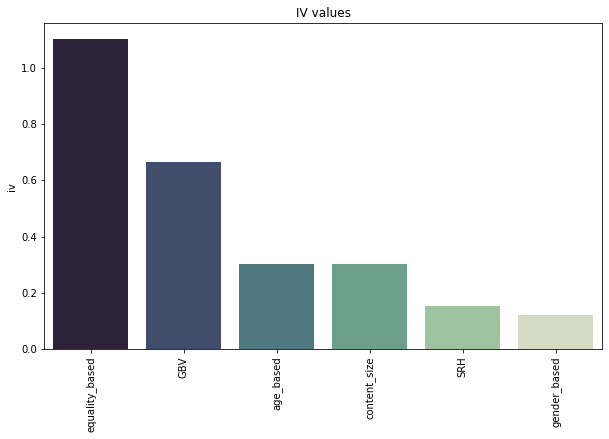

In [60]:
ar.draw_iv(feats, iv)

## Weight of evidence analysis

In [71]:
(content_size_iv_df, content_size_iv_value) = iv.calculate_iv(feats[0])
(gender_based_iv_df, gender_based_iv_value) = iv.calculate_iv(feats[1])
(age_based_iv_df, age_based_iv_value) = iv.calculate_iv(feats[2])
(equality_based_iv_df, equality_based_iv_value) = iv.calculate_iv(feats[3])
(GBV_iv_df, GBV_iv_value) = iv.calculate_iv(feats[4])
(SRH_iv_df, SRH_iv_value) = iv.calculate_iv(feats[5])

/home/yony/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [72]:
content_size_iv_df

,content_size,count,good,bad,perc_good,perc_bad,perc_diff,woe,iv
0,long,118,38,80,0.791667,0.536913,0.254754,0.388305,0.098922
1,medium,41,5,36,0.104167,0.241611,-0.137444,-0.841336,0.115637
2,short,38,5,33,0.104167,0.221477,-0.117310,-0.754324,0.088490


In [73]:
sub_topics = {"content_size": ["short", "meduim", "long"],
              "gender_based": ["gender", "girl", "women", "female"],
              "age_based": ["youth", "Adolescent", "teenager", "child"],
              "equality_based": ["equality", "court", "justice", "society", "our voice"],
              "GBV": ["gender-based violence", "rape", "sexual exploitation", "sexual harassment",
                      "child sexual abuse", "sexual violence", "forced marriage"],
              "SRH": ["Reproductive health", "family planning", "pregnant", "Abortion", 
                      "Menstrual cycle", "condom", "HIV/AIDS"]
             }

# rename columns and add new ones
content_size_iv_df = content_size_iv_df.rename(columns={"content_size": "contents"})
content_size_iv_df["sub_topics"] = "content_size"

gender_based_iv_df = gender_based_iv_df.rename(columns={"gender_based": "contents"})
gender_based_iv_df["sub_topics"] = "gender_based"

age_based_iv_df = age_based_iv_df.rename(columns={"age_based": "contents"})
age_based_iv_df["sub_topics"] = "age_based"

equality_based_iv_df = equality_based_iv_df.rename(columns={"equality_based": "contents"})
equality_based_iv_df["sub_topics"] = "equality_based"

GBV_iv_df = GBV_iv_df.rename(columns={"GBV": "contents"})
GBV_iv_df["sub_topics"] = "GBV"

SRH_iv_df = SRH_iv_df.rename(columns={"SRH": "contents"})
SRH_iv_df["sub_topics"] = "SRH"

# concatinating the dataframes
frames = [content_size_iv_df, gender_based_iv_df, age_based_iv_df, equality_based_iv_df, GBV_iv_df, SRH_iv_df]
woe_df = pd.concat(frames)
woe_df = woe_df[["sub_topics", "contents", "woe"]]
woe_df = woe_df[woe_df["contents"] != ""]
woe_df = woe_df.set_index("contents")
woe_df.to_csv('../data/woe_data.csv')
woe_df

,sub_topics,woe
contents,,
long,content_size,0.388305
medium,content_size,-0.841336
short,content_size,-0.754324
female,gender_based,0.321815
gender,gender_based,0.091291
girl,gender_based,0.439598
women,gender_based,-0.140220
Adolescent,age_based,1.538210
child,age_based,-1.234378


/home/yony/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


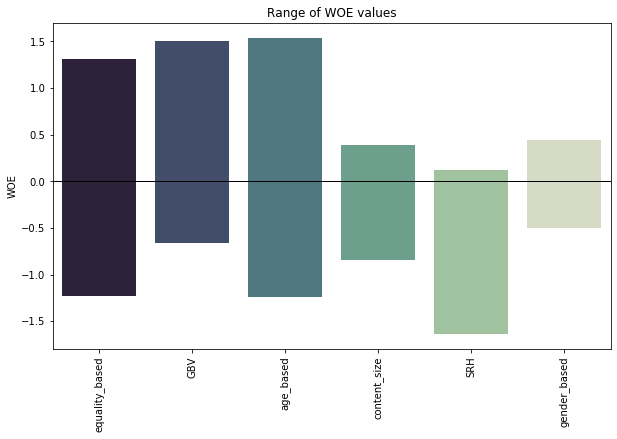

In [74]:
ar.draw_woe_extremes(feats, iv)

/home/yony/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yony/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yony/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


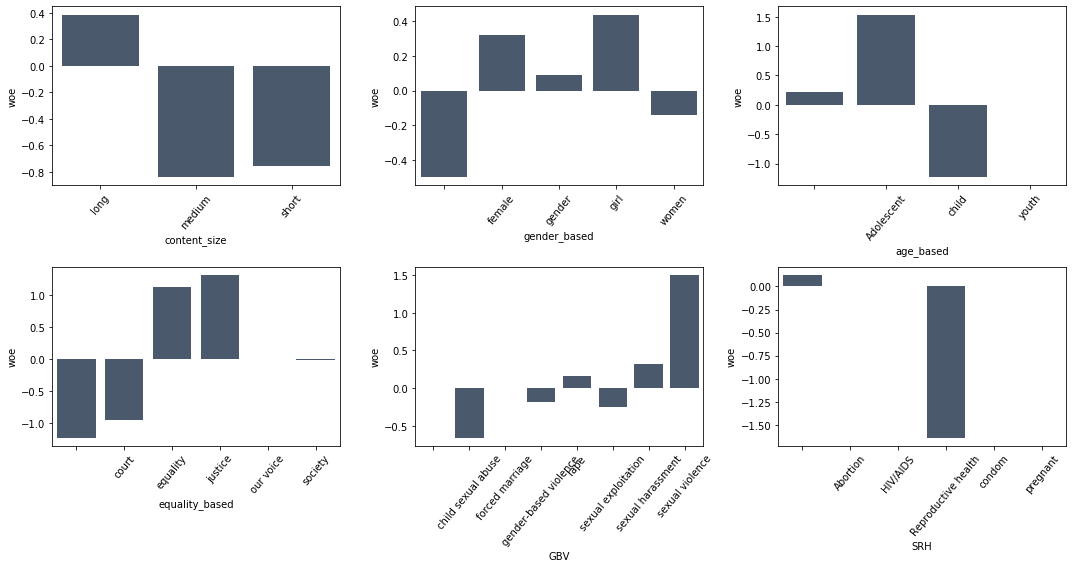

In [75]:
f_draw = ["content_size", "gender_based", "age_based", "equality_based", "GBV", "SRH"]
feats_draw = [v for k, v in feats_dict.items() if k in f_draw]
ar.draw_woe_multiplot(feats_draw, iv)

In [76]:
df["gender_based"].value_counts()

women     64
          49
girl      48
gender    23
female    13
Name: gender_based, dtype: int64